In [164]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew, kurtosis
from scipy.fftpack import fft
from scipy.signal import find_peaks
%matplotlib inline

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

from sklearn.model_selection import GridSearchCV, train_test_split as split
from sklearn.preprocessing import StandardScaler
from imblearn.under_sampling import RandomUnderSampler

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import StackingClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.metrics import roc_auc_score, roc_curve

import joblib

### Loading data

In [2]:
train_df = pd.read_parquet('../data/train.parquet')
test_df = pd.read_parquet('../data/test.parquet')
sample_submission = pd.read_csv('../data/sample_submission.csv')

### Show data

In [3]:
train_df.head()

,id,dates,values,label
0,19114,"[2016-01-01, 2016-02-01, 2016-03-01, 2016-04-0...","[-1.86, 0.79, 1.4, 0.15, 0.0, -1.24, -1.46, 3....",0.0
1,22769,"[2016-05-01, 2016-06-01, 2016-07-01, 2016-08-0...","[-1.04, -3.48, 0.05, -0.13, -0.01, 0.03, 0.27,...",1.0
2,76935,"[2017-03-01, 2017-04-01, 2017-05-01, 2017-06-0...","[0.28, 0.63, 0.06, 0.96, -1.4, -0.3, 1.62, 1.1...",0.0
3,66297,"[2016-01-01, 2016-02-01, 2016-03-01, 2016-04-0...","[-0.33, 0.58, 1.1, -0.56, -0.95, -0.61, -0.7, ...",0.0
4,2191,"[2016-01-01, 2016-02-01, 2016-03-01, 2016-04-0...","[1.31, 0.5, -0.54, 0.95, 0.65, 0.83, -1.55, -0...",0.0


In [4]:
test_df.head()

,id,dates,values
0,6125,"[2016-01-01, 2016-02-01, 2016-03-01, 2016-04-0...","[1.85, -0.04, 0.19, -0.45, -0.75, -0.95, -2.91..."
1,26781,"[2016-01-01, 2016-02-01, 2016-03-01, 2016-04-0...","[-0.41, 0.39, -0.47, -0.9, -1.46, -0.51, 0.51,..."
2,13333,"[2016-06-01, 2016-07-01, 2016-08-01, 2016-09-0...","[-0.29, -1.26, 0.17, -1.22, 0.45, -0.94, 0.16,..."
3,53218,"[2016-01-01, 2016-02-01, 2016-03-01, 2016-04-0...","[-1.47, 1.55, -0.03, 0.57, -0.57, 0.6, 0.27, 1..."
4,84204,"[2016-01-01, 2016-02-01, 2016-03-01, 2016-04-0...","[2.33, 1.39, -1.03, -2.64, 1.89, 1.77, 1.43, 1..."


In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80000 entries, 0 to 79999
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   id      80000 non-null  int64  
 1   dates   80000 non-null  object 
 2   values  80000 non-null  object 
 3   label   80000 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 2.4+ MB


In [6]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      20000 non-null  int64 
 1   dates   20000 non-null  object
 2   values  20000 non-null  object
dtypes: int64(1), object(2)
memory usage: 468.9+ KB


### Distribution of classes

In [7]:
#Checking dataframe's shape
print(f'train shape: {train_df.shape}')
print(f'test shape: {test_df.shape}')

train shape: (80000, 4)
test shape: (20000, 3)


In [8]:
unique_values = train_df['label'].unique()
print(unique_values)

[0. 1.]


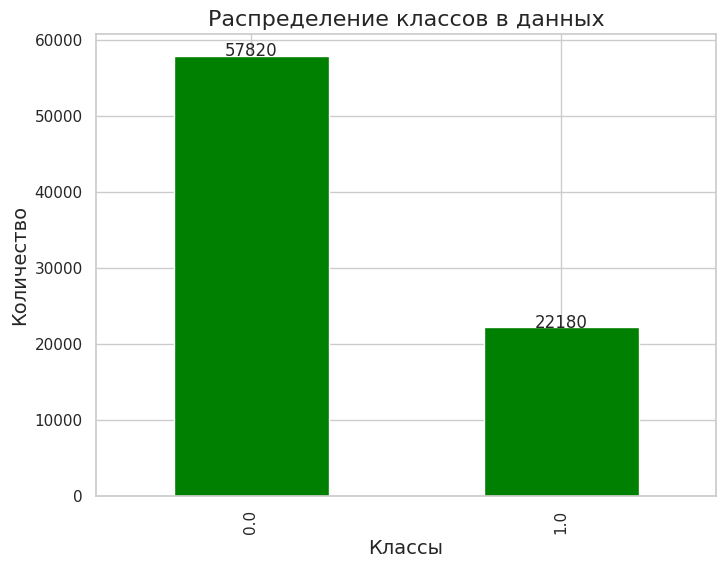

In [9]:
sns.set(style="whitegrid")
plt.figure(figsize=(8, 6))

train_df['label'].value_counts().plot(kind='bar', color='green')

plt.title('Распределение классов в данных', fontsize=16)
plt.xlabel('Классы', fontsize=14)
plt.ylabel('Количество', fontsize=14)

for i, value in enumerate(train_df['label'].value_counts()):
    plt.text(i, value + 5, str(value), ha='center', fontsize=12)

plt.show()

In [10]:
class_counts = train_df['label'].value_counts(normalize=True) * 100
print(class_counts)

label
0.0    72.275
1.0    27.725
Name: proportion, dtype: float64


##### Missing values

In [11]:
def check_missing_in_lists(row):
    return any(item is np.inf or item is np.nan or item is None for item in row) 

In [12]:
null_count = train_df[train_df['values'].apply(lambda x: check_missing_in_lists(x))].index.tolist() + train_df[train_df['dates'].apply(lambda x: check_missing_in_lists(x))].index.tolist()

In [13]:
len(null_count)

0

In [14]:
def fillna_in_lists(column):
    def fill_list(lst):
        if isinstance(lst, list):
            clean_lst = [x for x in lst if pd.notnull(x)]  
            if len(clean_lst) > 0:
                median_value = np.median(clean_lst)  
                return [x if pd.notnull(x) else median_value for x in lst]  
            else:
                return [0]*len(lst) 
        return lst  
    return column.apply(fill_list)

In [15]:
train_df['values'] = fillna_in_lists(train_df['values'])
train_df

,id,dates,values,label
0,19114,"[2016-01-01, 2016-02-01, 2016-03-01, 2016-04-0...","[-1.86, 0.79, 1.4, 0.15, 0.0, -1.24, -1.46, 3....",0.0
1,22769,"[2016-05-01, 2016-06-01, 2016-07-01, 2016-08-0...","[-1.04, -3.48, 0.05, -0.13, -0.01, 0.03, 0.27,...",1.0
2,76935,"[2017-03-01, 2017-04-01, 2017-05-01, 2017-06-0...","[0.28, 0.63, 0.06, 0.96, -1.4, -0.3, 1.62, 1.1...",0.0
3,66297,"[2016-01-01, 2016-02-01, 2016-03-01, 2016-04-0...","[-0.33, 0.58, 1.1, -0.56, -0.95, -0.61, -0.7, ...",0.0
4,2191,"[2016-01-01, 2016-02-01, 2016-03-01, 2016-04-0...","[1.31, 0.5, -0.54, 0.95, 0.65, 0.83, -1.55, -0...",0.0
...,...,...,...,...
79995,71474,"[2018-10-01, 2018-11-01, 2018-12-01, 2019-01-0...","[-0.15, -1.13, -0.87, 0.49, 0.87, 1.67, 1.91, ...",0.0
79996,36908,"[2016-07-01, 2016-08-01, 2016-09-01, 2016-10-0...","[-0.35, -1.31, 0.11, 1.46, 1.28, 1.12, 1.78, 1...",1.0
79997,63517,"[2016-03-01, 2016-04-01, 2016-05-01, 2016-06-0...","[-0.78, -2.27, -1.85, -0.67, -1.2, -2.02, 0.12...",0.0
79998,94731,"[2016-02-01, 2016-03-01, 2016-04-01, 2016-05-0...","[-2.29, -2.85, 0.92, -0.83, -1.75, -1.81, -2.2...",0.0


In [17]:
train_df['miss_value'] = train_df['dates'].apply(lambda x: any(pd.isnull(x)))
print(train_df['miss_value'].unique())

[False]


In [18]:
train_df = train_df.drop(columns=['miss_value'], axis=1)
train_df

,id,dates,values,label
0,19114,"[2016-01-01, 2016-02-01, 2016-03-01, 2016-04-0...","[-1.86, 0.79, 1.4, 0.15, 0.0, -1.24, -1.46, 3....",0.0
1,22769,"[2016-05-01, 2016-06-01, 2016-07-01, 2016-08-0...","[-1.04, -3.48, 0.05, -0.13, -0.01, 0.03, 0.27,...",1.0
2,76935,"[2017-03-01, 2017-04-01, 2017-05-01, 2017-06-0...","[0.28, 0.63, 0.06, 0.96, -1.4, -0.3, 1.62, 1.1...",0.0
3,66297,"[2016-01-01, 2016-02-01, 2016-03-01, 2016-04-0...","[-0.33, 0.58, 1.1, -0.56, -0.95, -0.61, -0.7, ...",0.0
4,2191,"[2016-01-01, 2016-02-01, 2016-03-01, 2016-04-0...","[1.31, 0.5, -0.54, 0.95, 0.65, 0.83, -1.55, -0...",0.0
...,...,...,...,...
79995,71474,"[2018-10-01, 2018-11-01, 2018-12-01, 2019-01-0...","[-0.15, -1.13, -0.87, 0.49, 0.87, 1.67, 1.91, ...",0.0
79996,36908,"[2016-07-01, 2016-08-01, 2016-09-01, 2016-10-0...","[-0.35, -1.31, 0.11, 1.46, 1.28, 1.12, 1.78, 1...",1.0
79997,63517,"[2016-03-01, 2016-04-01, 2016-05-01, 2016-06-0...","[-0.78, -2.27, -1.85, -0.67, -1.2, -2.02, 0.12...",0.0
79998,94731,"[2016-02-01, 2016-03-01, 2016-04-01, 2016-05-0...","[-2.29, -2.85, 0.92, -0.83, -1.75, -1.81, -2.2...",0.0


In [19]:
test_df['miss_value'] = test_df['dates'].apply(lambda x: any(pd.isnull(x)))
print(test_df['miss_value'].unique())

[False]


### 1. Statistical Features

In [20]:
def generate_stat_features(data):
    stat_features = {}

    stat_features['mean'] = data['values'].apply(np.mean)
    stat_features['std_value'] = data['values'].apply(np.std)
    stat_features['min_value'] = data['values'].apply(np.min)
    stat_features['max_value'] = data['values'].apply(np.max)
    stat_features['median_value'] = data['values'].apply(np.median)
    stat_features['q1_value'] = data['values'].apply(lambda x: np.percentile(x, 25))
    stat_features['q3_value'] = data['values'].apply(lambda x: np.percentile(x, 75))
    stat_features['skewness_value'] = data['values'].apply(skew)
    stat_features['kurtosis_value'] = data['values'].apply(kurtosis)
    stat_features['peaks_value'] = data['values'].apply(lambda x: len(find_peaks(x)[0]))
    
    stat_features_df = pd.DataFrame(stat_features)
    
    return stat_features_df

In [77]:
def fill_missing_values(data):
    data['values'] = data['values'].apply(lambda x: [0 if v is None else v for v in x])
    data['dates'] = data['dates'].apply(lambda x: [0 if d is None else d for d in x])
    return data

train_df_filled = fill_missing_values(train_df)
train_stat = generate_stat_features(train_df_filled)
merged_train_df = train_df_filled.merge(train_stat, left_index=True, right_index=True, how='left')

merged_train_df = merged_train_df.fillna(0)

train_df_cleaned = merged_train_df[train_df.columns]  
train_stat_cleaned = merged_train_df[train_stat.columns] 

print("Очищенный train_df:", train_df_cleaned.isnull().sum())
print("Очищенный train_stat:", train_stat_cleaned.isnull().sum())

Очищенный train_df: id        0
dates     0
values    0
label     0
dtype: int64
Очищенный train_stat: mean              0
std_value         0
min_value         0
max_value         0
median_value      0
q1_value          0
q3_value          0
skewness_value    0
kurtosis_value    0
peaks_value       0
dtype: int64


### 2. Time-Domain Features (Autocorrelation)

In [26]:
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

def detect_autocorrelation(data, lag=1, threshold=0.5):
    """
    1 - положительная автокорреляция выше порога,
    0 - автокорреляции нет,
    -1 - отрицательная автокорреляция ниже порога.
    """
    data_copy = data.copy()
    
    def autocorr_classification(x, lag, threshold):
        x_array = np.array(x)
        
        if np.std(x_array) == 0:
            return 0  
        else:
            autocorr_value = pd.Series(x_array).autocorr(lag=lag)
            if autocorr_value > threshold:
                return 1 
            elif autocorr_value < -threshold:
                return -1  
            else:
                return 0  

    data_copy['autocorr_sign'] = data_copy['values'].apply(lambda x: autocorr_classification(x, lag, threshold))
    
    return data_copy

In [83]:
autocorr_train = detect_autocorrelation(train_df_cleaned, lag=1, threshold=0.3)
autocorr_train

,id,dates,values,label,autocorr_sign
0,19114,"[2016-01-01, 2016-02-01, 2016-03-01, 2016-04-0...","[-1.86, 0.79, 1.4, 0.15, 0.0, -1.24, -1.46, 3....",0.0,0
1,22769,"[2016-05-01, 2016-06-01, 2016-07-01, 2016-08-0...","[-1.04, -3.48, 0.05, -0.13, -0.01, 0.03, 0.27,...",1.0,0
2,76935,"[2017-03-01, 2017-04-01, 2017-05-01, 2017-06-0...","[0.28, 0.63, 0.06, 0.96, -1.4, -0.3, 1.62, 1.1...",0.0,1
3,66297,"[2016-01-01, 2016-02-01, 2016-03-01, 2016-04-0...","[-0.33, 0.58, 1.1, -0.56, -0.95, -0.61, -0.7, ...",0.0,1
4,2191,"[2016-01-01, 2016-02-01, 2016-03-01, 2016-04-0...","[1.31, 0.5, -0.54, 0.95, 0.65, 0.83, -1.55, -0...",0.0,0
...,...,...,...,...,...
79995,71474,"[2018-10-01, 2018-11-01, 2018-12-01, 2019-01-0...","[-0.15, -1.13, -0.87, 0.49, 0.87, 1.67, 1.91, ...",0.0,0
79996,36908,"[2016-07-01, 2016-08-01, 2016-09-01, 2016-10-0...","[-0.35, -1.31, 0.11, 1.46, 1.28, 1.12, 1.78, 1...",1.0,1
79997,63517,"[2016-03-01, 2016-04-01, 2016-05-01, 2016-06-0...","[-0.78, -2.27, -1.85, -0.67, -1.2, -2.02, 0.12...",0.0,1
79998,94731,"[2016-02-01, 2016-03-01, 2016-04-01, 2016-05-0...","[-2.29, -2.85, 0.92, -0.83, -1.75, -1.81, -2.2...",0.0,1


In [84]:
autocorr_test = detect_autocorrelation(test_df_cleaned, lag=1, threshold=0.3)
autocorr_test

,id,dates,values,miss_value,autocorr_sign
0,6125,"[2016-01-01, 2016-02-01, 2016-03-01, 2016-04-0...","[1.85, -0.04, 0.19, -0.45, -0.75, -0.95, -2.91...",False,1
1,26781,"[2016-01-01, 2016-02-01, 2016-03-01, 2016-04-0...","[-0.41, 0.39, -0.47, -0.9, -1.46, -0.51, 0.51,...",False,0
2,13333,"[2016-06-01, 2016-07-01, 2016-08-01, 2016-09-0...","[-0.29, -1.26, 0.17, -1.22, 0.45, -0.94, 0.16,...",False,1
3,53218,"[2016-01-01, 2016-02-01, 2016-03-01, 2016-04-0...","[-1.47, 1.55, -0.03, 0.57, -0.57, 0.6, 0.27, 1...",False,0
4,84204,"[2016-01-01, 2016-02-01, 2016-03-01, 2016-04-0...","[2.33, 1.39, -1.03, -2.64, 1.89, 1.77, 1.43, 1...",False,1
...,...,...,...,...,...
19995,80341,"[2016-03-01, 2016-04-01, 2016-05-01, 2016-06-0...","[3.01, -0.58, 1.55, 0.48, -0.35, 1.93, 3.86, 2...",False,1
19996,5891,"[2016-01-01, 2016-02-01, 2016-03-01, 2016-04-0...","[0.66, 1.3, 2.78, -0.25, -1.97, -0.55, -1.08, ...",False,1
19997,29091,"[2017-01-01, 2017-02-01, 2017-03-01, 2017-04-0...","[0.09, 0.44, 1.55, 0.15, 0.3, 0.19, 0.34, 1.05...",False,1
19998,85877,"[2017-04-01, 2017-05-01, 2017-06-01, 2017-07-0...","[0.28, 1.92, 1.14, 2.4, 1.46, 1.08, -0.12, 0.6...",False,0


In [86]:
merged_train_df = train_stat_cleaned.join(autocorr_train[['autocorr_sign', 'label']])
merged_test_df = test_stat_cleaned.join(autocorr_test[['autocorr_sign']])

In [87]:
merged_train_df.head()

,mean,std_value,min_value,max_value,median_value,q1_value,q3_value,skewness_value,kurtosis_value,peaks_value,autocorr_sign,label
0,0.023710,1.337272,-4.840000,3.49,-0.110000,-0.6825,0.7700,-0.304166,1.889654,19,0,0.0
1,-0.310777,1.556337,-3.534409,2.92,-0.274409,-1.0400,0.7100,-0.011952,-0.107257,14,0,1.0
2,-0.046042,1.065023,-1.950000,2.61,-0.145000,-0.8775,0.6150,0.377148,-0.272738,15,1,0.0
3,-0.130000,1.158201,-2.220000,2.49,-0.345000,-0.9500,0.8250,0.112395,-0.849629,11,1,0.0
4,-0.270536,1.270529,-2.500000,2.87,-0.475000,-1.2500,0.6775,0.398655,-0.587199,17,0,0.0


In [88]:
print(merged_train_df['autocorr_sign'].unique())

[ 0  1 -1]


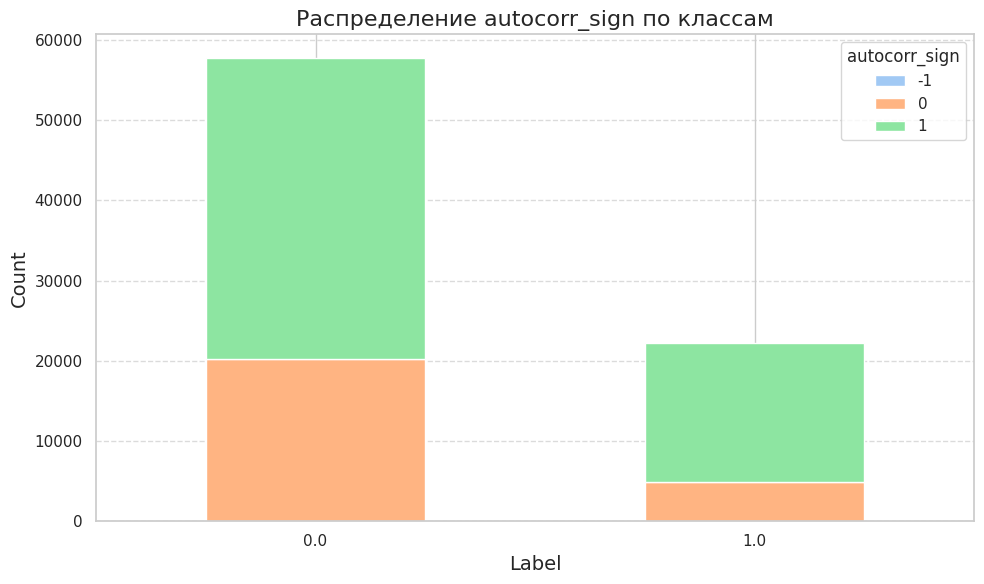

In [89]:
class_autocorr_counts = merged_train_df.groupby(['label', 'autocorr_sign']).size().unstack()

sns.set(style="whitegrid")
ax = class_autocorr_counts.plot(kind='bar', stacked=True, figsize=(10, 6), color=sns.color_palette("pastel"))

plt.title('Распределение autocorr_sign по классам', fontsize=16)
plt.xlabel('Label', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(rotation=0) 
plt.legend(title='autocorr_sign', loc='upper right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout() 
plt.show()

In [90]:
merged_train_df['autocorr_sign'] = merged_train_df['autocorr_sign'].replace(-1, 0)

In [91]:
merged_test_df['autocorr_sign'] = merged_test_df['autocorr_sign'].replace(-1, 0)

### 3. Frequency-Domain Features

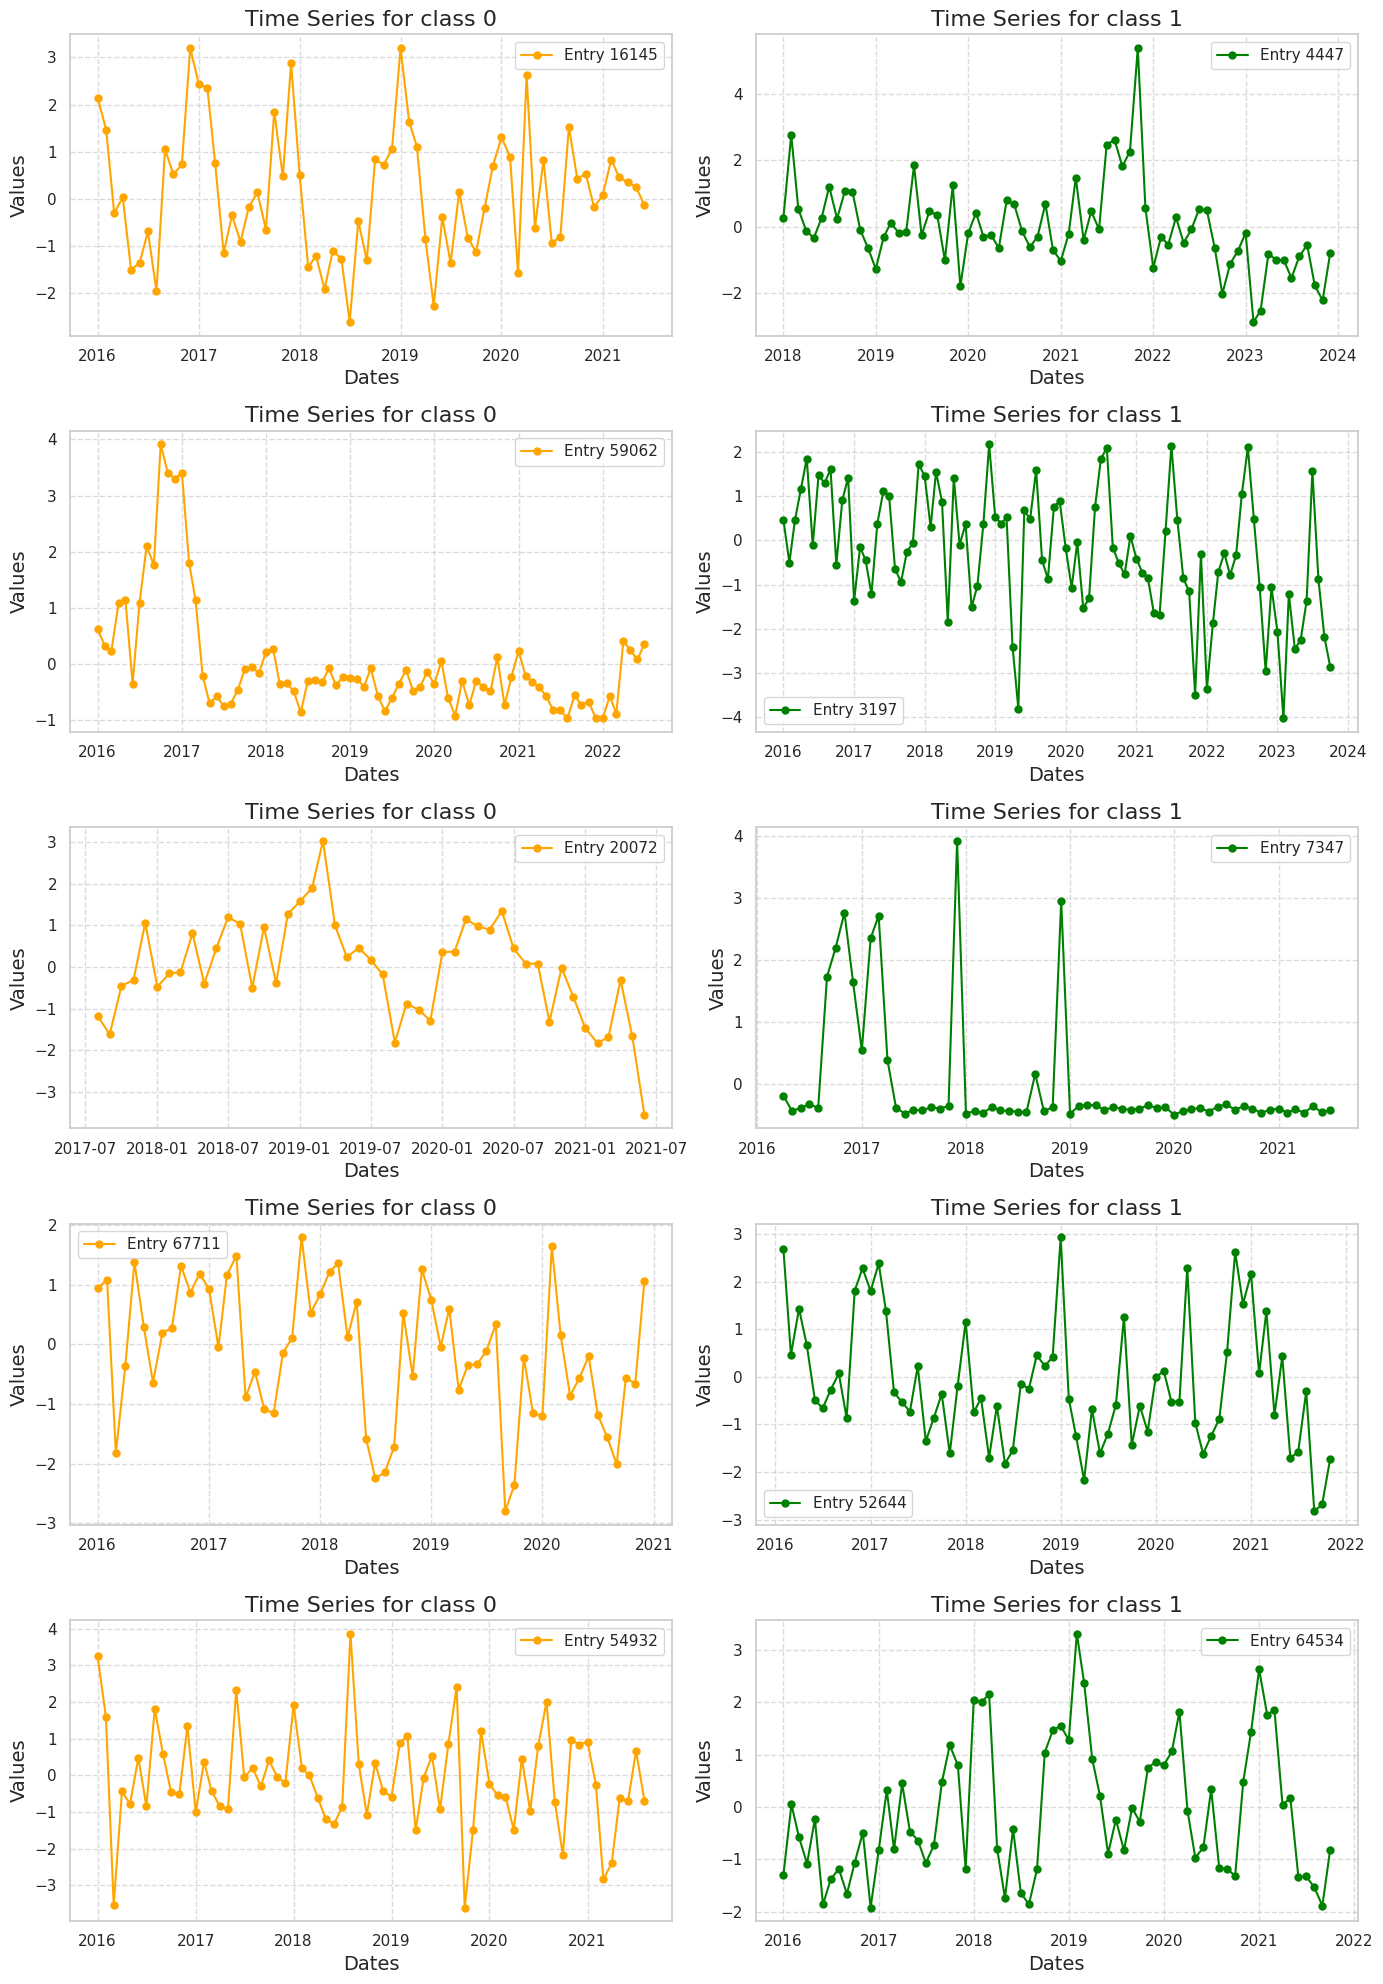

In [35]:
class_1_subset = train_df_cleaned[train_df_cleaned['label'] == 1].sample(n=5, random_state=1)  
class_0_subset = train_df_cleaned[train_df_cleaned['label'] == 0].sample(n=5, random_state=1)  

def plot_time_series_for_class(subset, class_label, color, ax):
    for index, row in subset.iterrows():
        ax.plot(row['dates'], row['values'], marker='o', markersize=5, color=color, label=f'Entry {index}')  

    ax.set_title(f'Time Series for class {class_label}', fontsize=16)
    ax.set_xlabel('Dates', fontsize=14)
    ax.set_ylabel('Values', fontsize=14)
    ax.legend()
    ax.grid(True, linestyle='--', alpha=0.7)

sns.set(style="whitegrid")

fig, axs = plt.subplots(5, 2, figsize=(14, 20))

for i, ax in enumerate(axs[:, 0]):
    if i < len(class_0_subset):  
        plot_time_series_for_class(class_0_subset.iloc[[i]], 0, color='orange', ax=ax)


for i, ax in enumerate(axs[:, 1]):
    if i < len(class_1_subset):  
        plot_time_series_for_class(class_1_subset.iloc[[i]], 1, color='green', ax=ax)

plt.tight_layout()
plt.show()

In [92]:
def extract_features(data):
    data_copy = data.copy()
    def calculate_amplitude(group):
        time_series = group['values'] 
        fft_values = np.fft.rfft(time_series)
        amplitude = np.abs(fft_values) // 2
        
        group['mean_amplitude'] = np.mean(amplitude)
        return group
    
    
    data_copy['mean_amplitude'] = data_copy['values'].apply(lambda x: np.mean(np.abs(np.fft.rfft(x)) // 2))
    
    return data_copy


In [116]:
def fill_missing_values_with_median(data, feature):
    data_filled = data.copy()
    
    for label in data_filled['label'].unique():
        median_value = data_filled[data_filled['label'] == label][feature].apply(
            lambda x: np.median(x) if isinstance(x, (list, np.ndarray)) and len(x) > 0 else 0
        ).median()
        
        data_filled.loc[data_filled['label'] == label, feature] = data_filled.loc[data_filled['label'] == label, feature].apply(
            lambda x: [median_value if v is None else v for v in x] if isinstance(x, (list, np.ndarray)) else x
        )
    
    return data_filled

In [117]:
train_df_amplit = extract_features(train_df_cleaned)
merged_train_df_fd = merged_train_df.merge(train_df_amplit[['mean_amplitude']], left_index=True, right_index=True, how='left')
merged_train_df_filled = fill_missing_values_with_median(merged_train_df_fd, 'mean_amplitude')
merged_train_df_filled = merged_train_df_filled.fillna(0)

In [120]:
test_df_amplit = extract_features(test_df_cleaned)
merged_test_df_fd = merged_test_df.merge(test_df_amplit[['mean_amplitude']], left_index=True, right_index=True, how='left')
merged_test_df_fd = merged_test_df_fd.fillna(0)

In [121]:
merged_train_df_filled

,mean,std_value,min_value,max_value,median_value,q1_value,q3_value,skewness_value,kurtosis_value,peaks_value,autocorr_sign,label,mean_amplitude
0,0.023710,1.337272,-4.840000,3.49,-0.110000,-0.682500,0.7700,-0.304166,1.889654,19,0,0.0,4.062500
1,-0.310777,1.556337,-3.534409,2.92,-0.274409,-1.040000,0.7100,-0.011952,-0.107257,14,0,1.0,4.478261
2,-0.046042,1.065023,-1.950000,2.61,-0.145000,-0.877500,0.6150,0.377148,-0.272738,15,1,0.0,2.400000
3,-0.130000,1.158201,-2.220000,2.49,-0.345000,-0.950000,0.8250,0.112395,-0.849629,11,1,0.0,2.280000
4,-0.270536,1.270529,-2.500000,2.87,-0.475000,-1.250000,0.6775,0.398655,-0.587199,17,0,0.0,3.655172
...,...,...,...,...,...,...,...,...,...,...,...,...,...
79995,0.163818,1.303965,-3.640000,2.56,0.160000,-0.360000,1.0150,-0.717290,0.981033,16,0,0.0,3.821429
79996,-0.112555,1.216413,-2.590000,2.16,-0.180000,-1.120319,1.1200,0.111317,-1.059264,16,1,1.0,3.185185
79997,-0.201373,1.182551,-2.890000,2.27,-0.140000,-0.905000,0.4950,-0.055628,-0.239816,17,1,0.0,3.153846
79998,-0.075397,1.491254,-2.850000,3.11,0.240000,-1.465000,0.9850,-0.142759,-0.978812,19,1,0.0,4.656250


In [122]:
print(merged_train_df_filled.isnull().sum())
print(merged_train_df_filled.shape)
print(merged_test_df_fd.isnull().sum())
print(merged_test_df_fd.shape)

mean              0
std_value         0
min_value         0
max_value         0
median_value      0
q1_value          0
q3_value          0
skewness_value    0
kurtosis_value    0
peaks_value       0
autocorr_sign     0
label             0
mean_amplitude    0
dtype: int64
(80000, 13)
mean              0
std_value         0
min_value         0
max_value         0
median_value      0
q1_value          0
q3_value          0
skewness_value    0
kurtosis_value    0
peaks_value       0
autocorr_sign     0
mean_amplitude    0
dtype: int64
(20000, 12)


### Distribution of features

In [123]:
selected_features = ['mean', 'std_value',	'min_value', 'max_value', 'median_value', 'q1_value', 'q3_value', 'skewness_value', 'kurtosis_value', 'autocorr_sign', 'peaks_value', 'mean_amplitude']

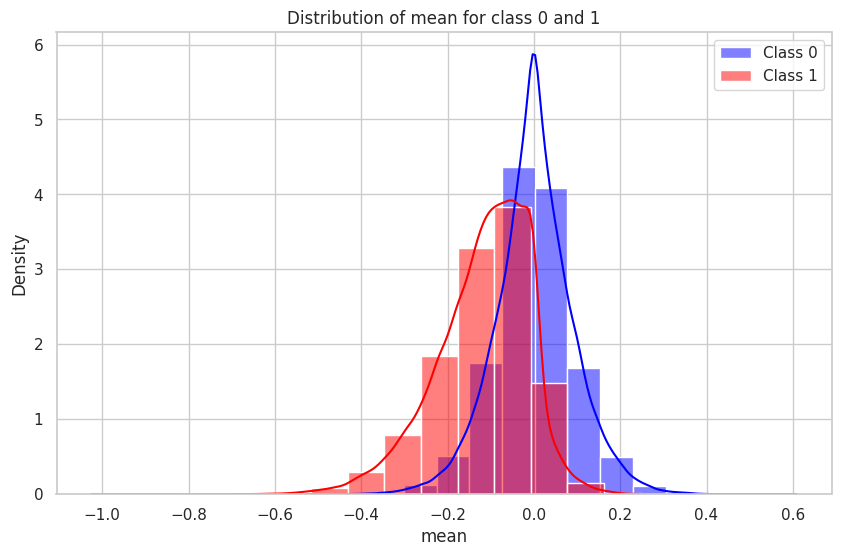

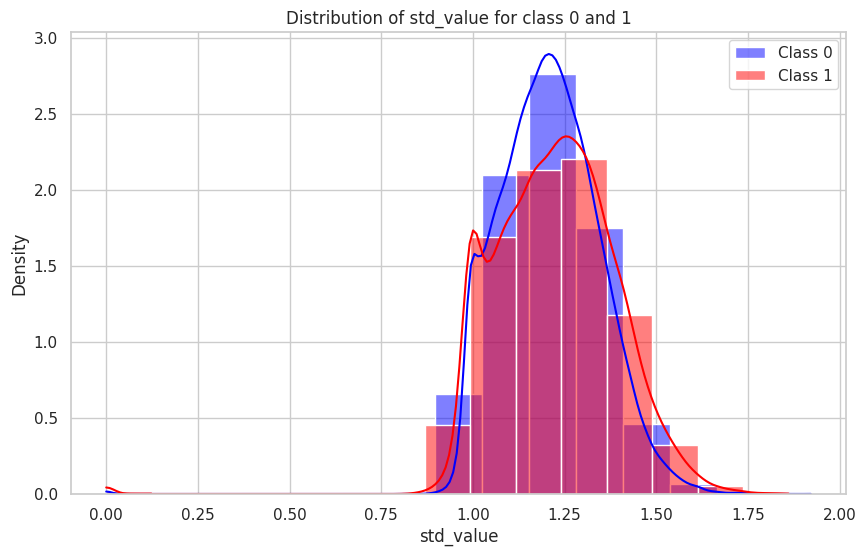

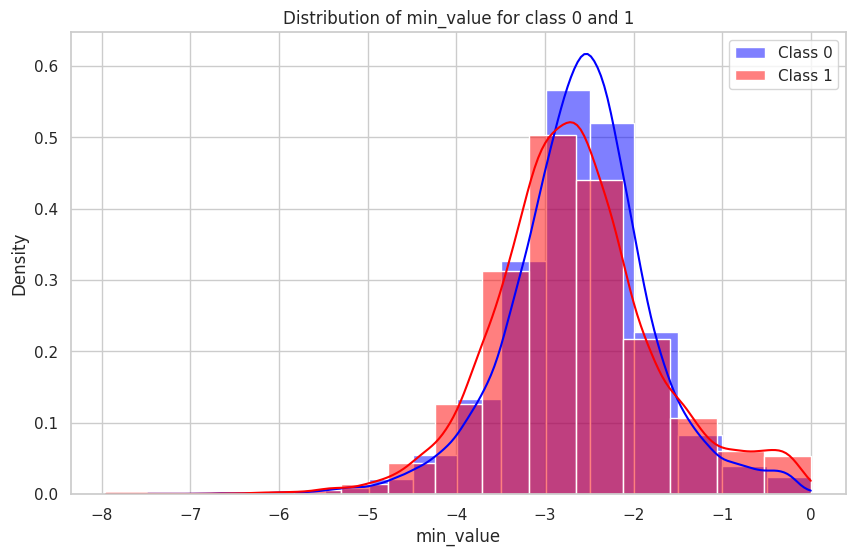

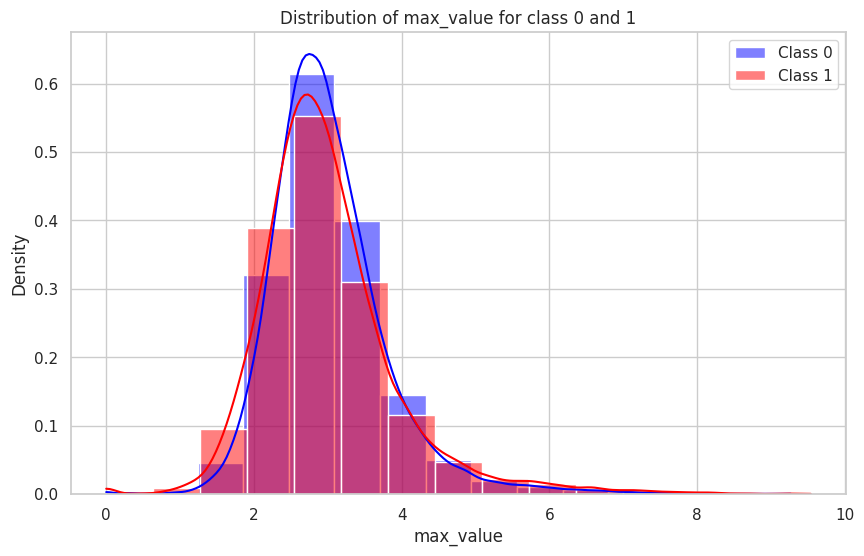

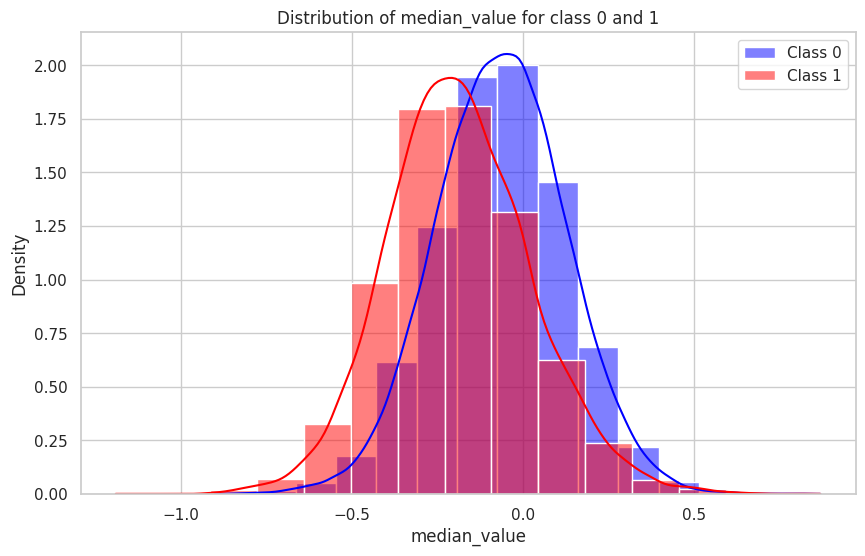

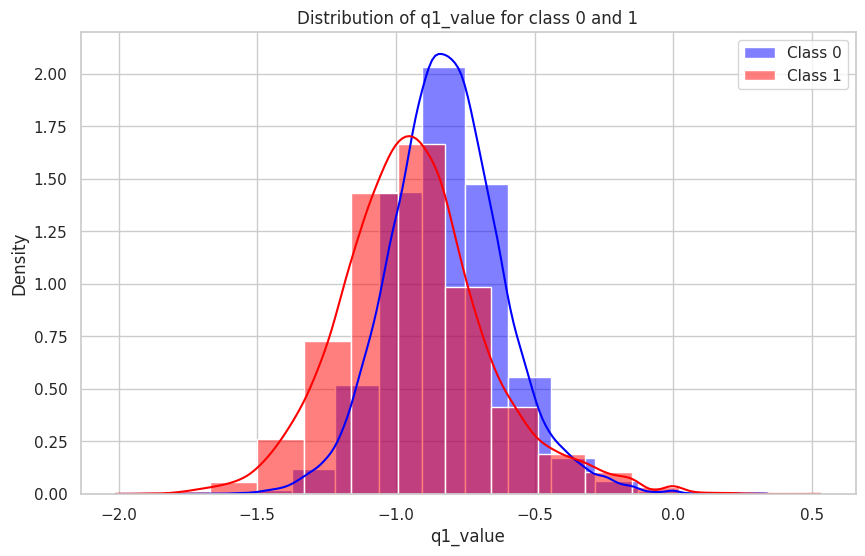

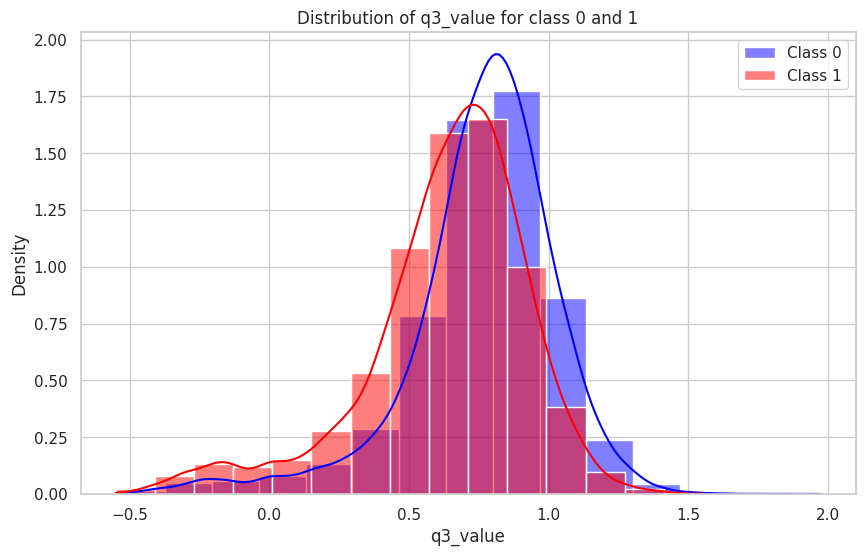

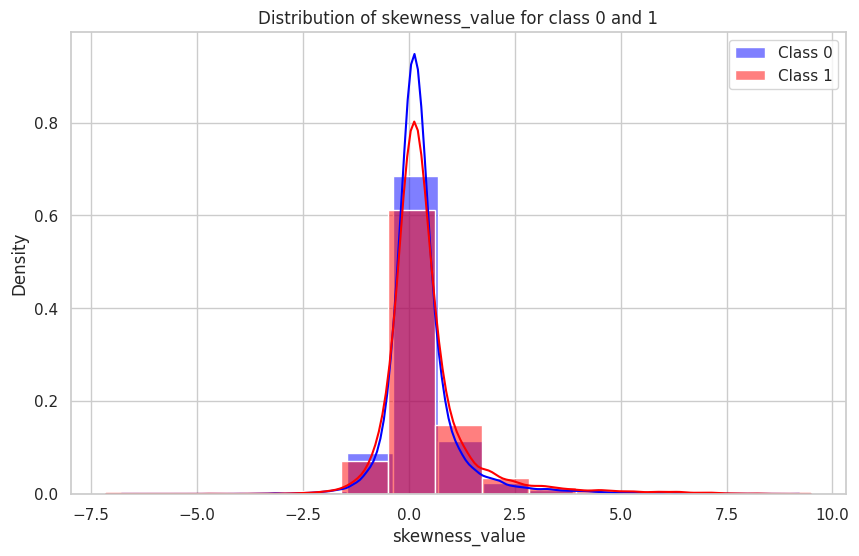

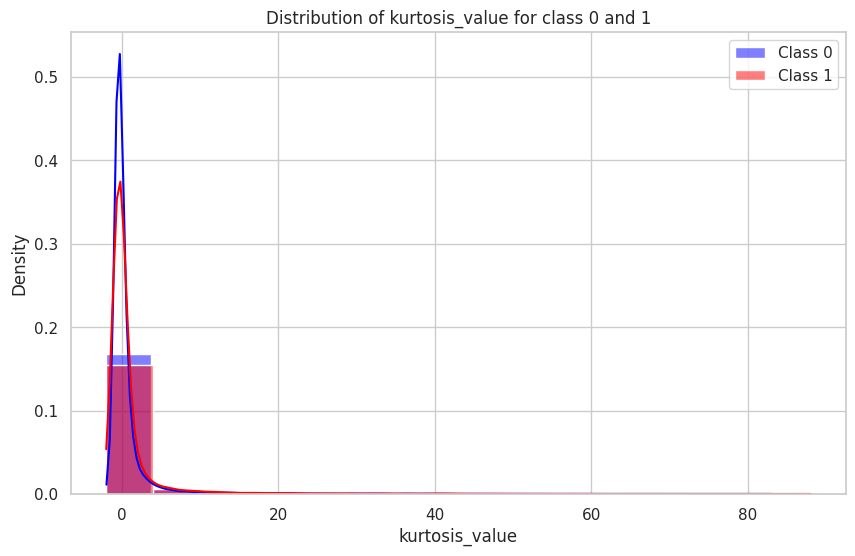

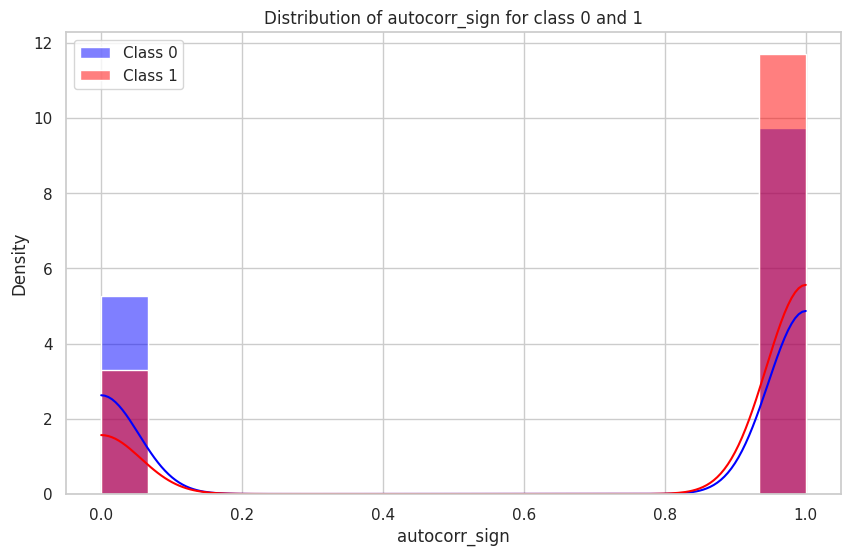

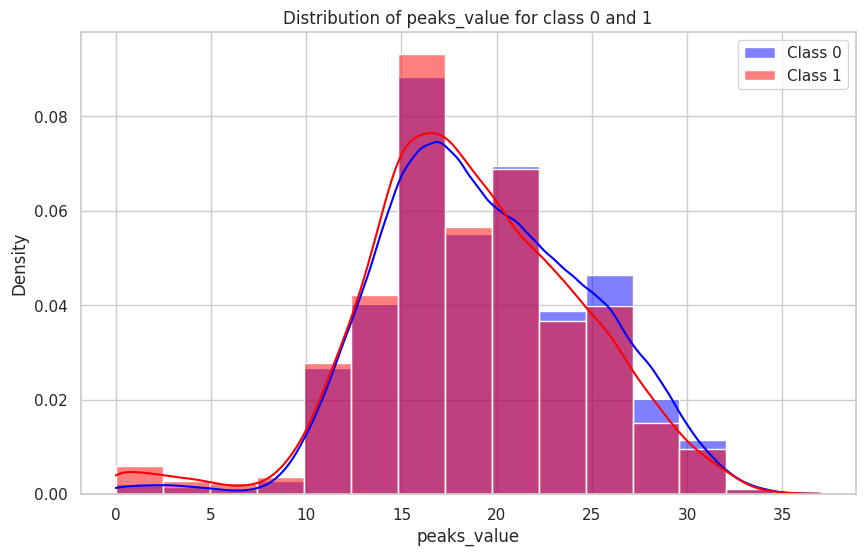

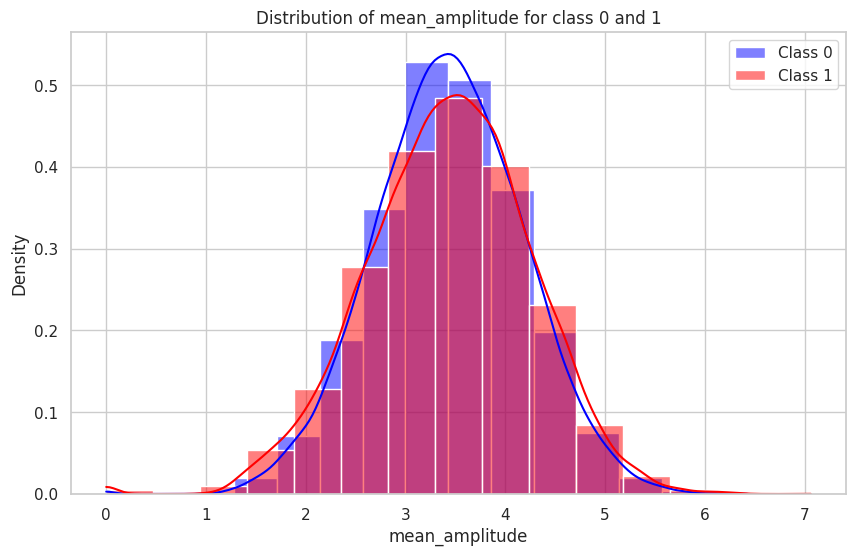

In [124]:
class_0 = merged_train_df_filled[merged_train_df_filled['label'] == 0.0]
class_1 = merged_train_df_filled[merged_train_df_filled['label'] == 1.0]

for feature in selected_features:
    plt.figure(figsize=(10, 6))
    sns.histplot(class_0[feature], color='blue', label='Class 0', kde=True, stat='density', bins=15)
    sns.histplot(class_1[feature], color='red', label='Class 1', kde=True, stat='density', bins=15)
    plt.title(f"Distribution of {feature} for class 0 and 1")
    plt.xlabel(feature)
    plt.ylabel('Density')
    plt.legend()
    plt.show()

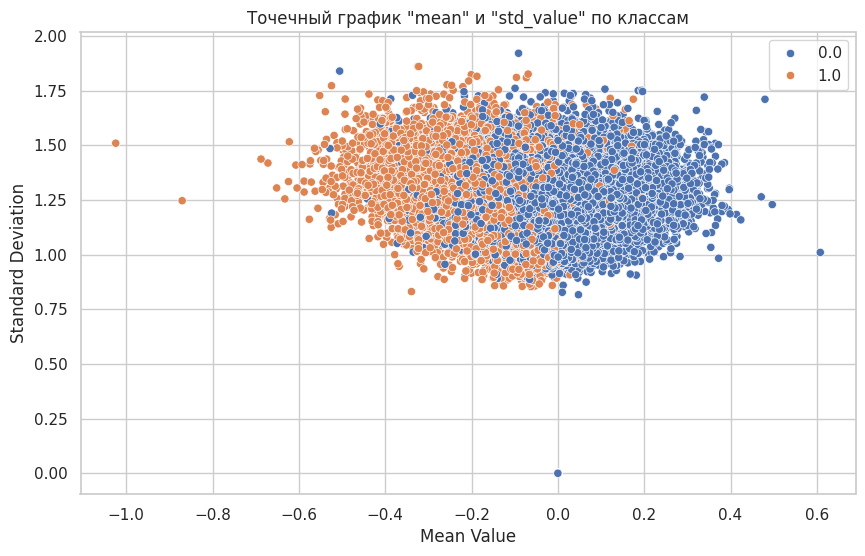

In [125]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='mean', y='std_value', hue='label', data=merged_train_df_filled)
plt.title('Точечный график "mean" и "std_value" по классам')
plt.xlabel('Mean Value')
plt.ylabel('Standard Deviation')
plt.legend(loc='upper right')
plt.show()

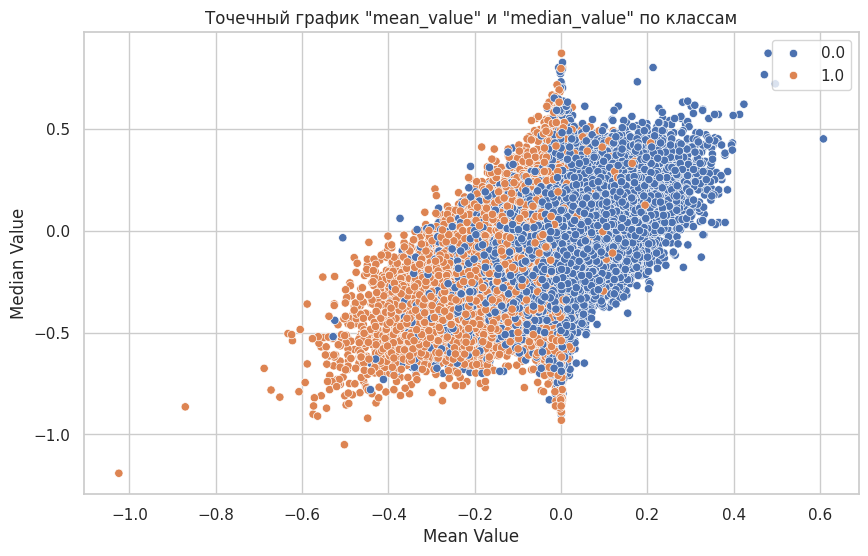

In [126]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='mean', y='median_value', hue='label', data=merged_train_df_filled)
plt.title('Точечный график "mean_value" и "median_value" по классам')
plt.xlabel('Mean Value')
plt.ylabel('Median Value')
plt.legend(loc='upper right')
plt.show()

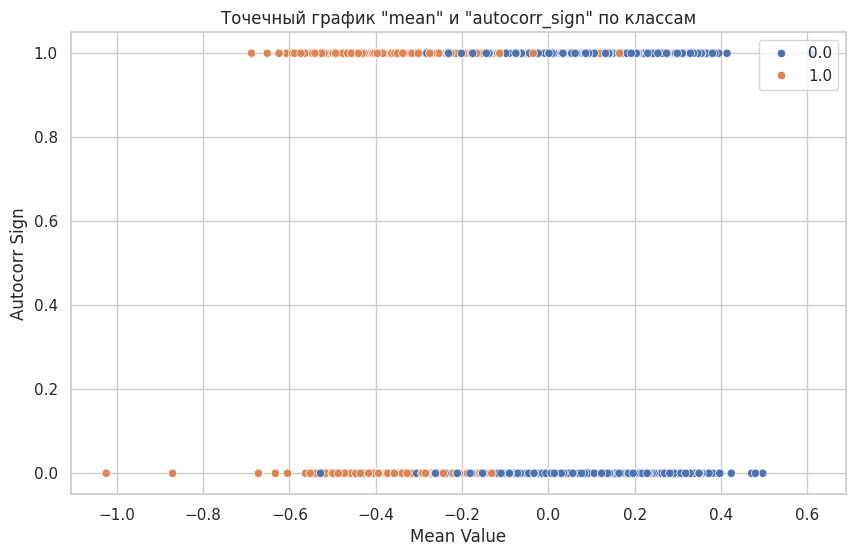

In [127]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='mean', y='autocorr_sign', hue='label', data=merged_train_df_filled)
plt.title('Точечный график "mean" и "autocorr_sign" по классам')
plt.xlabel('Mean Value')
plt.ylabel('Autocorr Sign')
plt.legend(loc='upper right')
plt.show()

In [128]:
merged_train_df_filled

,mean,std_value,min_value,max_value,median_value,q1_value,q3_value,skewness_value,kurtosis_value,peaks_value,autocorr_sign,label,mean_amplitude
0,0.023710,1.337272,-4.840000,3.49,-0.110000,-0.682500,0.7700,-0.304166,1.889654,19,0,0.0,4.062500
1,-0.310777,1.556337,-3.534409,2.92,-0.274409,-1.040000,0.7100,-0.011952,-0.107257,14,0,1.0,4.478261
2,-0.046042,1.065023,-1.950000,2.61,-0.145000,-0.877500,0.6150,0.377148,-0.272738,15,1,0.0,2.400000
3,-0.130000,1.158201,-2.220000,2.49,-0.345000,-0.950000,0.8250,0.112395,-0.849629,11,1,0.0,2.280000
4,-0.270536,1.270529,-2.500000,2.87,-0.475000,-1.250000,0.6775,0.398655,-0.587199,17,0,0.0,3.655172
...,...,...,...,...,...,...,...,...,...,...,...,...,...
79995,0.163818,1.303965,-3.640000,2.56,0.160000,-0.360000,1.0150,-0.717290,0.981033,16,0,0.0,3.821429
79996,-0.112555,1.216413,-2.590000,2.16,-0.180000,-1.120319,1.1200,0.111317,-1.059264,16,1,1.0,3.185185
79997,-0.201373,1.182551,-2.890000,2.27,-0.140000,-0.905000,0.4950,-0.055628,-0.239816,17,1,0.0,3.153846
79998,-0.075397,1.491254,-2.850000,3.11,0.240000,-1.465000,0.9850,-0.142759,-0.978812,19,1,0.0,4.656250


### Correlation matrix

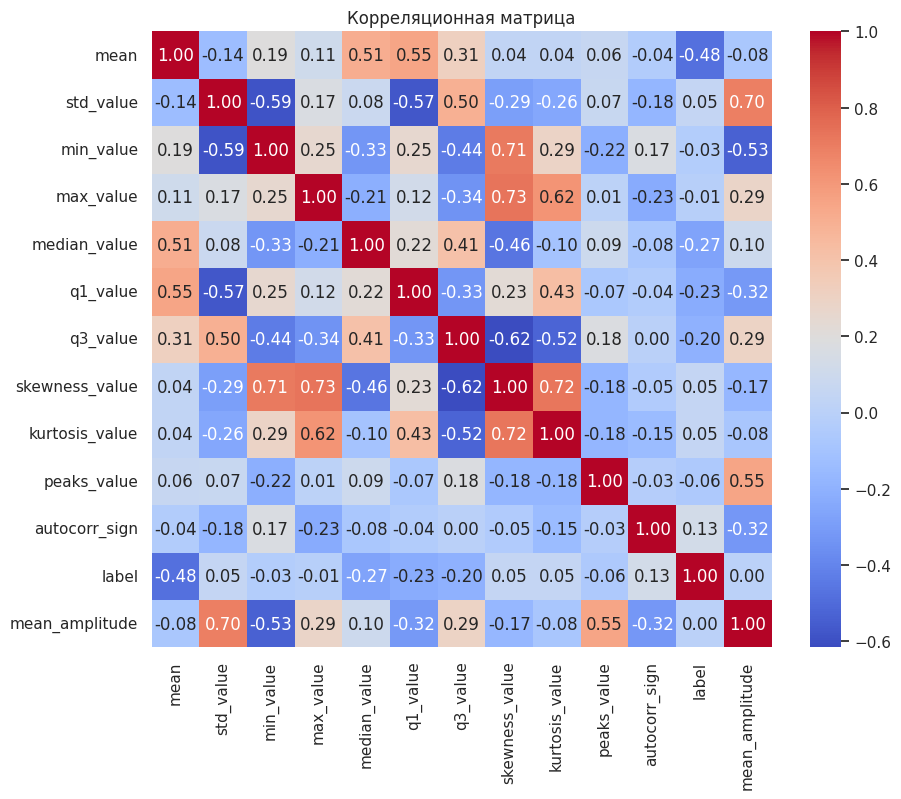

In [129]:
correlation_matrix = merged_train_df_fd.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Корреляционная матрица')
plt.show()

##### Delete features with hight correlation

In [130]:
threshold = 0.6

high_corr_pairs = set()
for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > threshold:
            colname = correlation_matrix.columns[i]
            high_corr_pairs.add((colname, correlation_matrix.columns[j]))

print("features with hight correlation:")
for pair in high_corr_pairs:
    print(pair)

features with hight correlation:
('kurtosis_value', 'skewness_value')
('skewness_value', 'min_value')
('kurtosis_value', 'max_value')
('mean_amplitude', 'std_value')
('skewness_value', 'max_value')
('skewness_value', 'q3_value')


In [133]:
to_remove = set()

for pair in high_corr_pairs:
    to_remove.add(pair[1])

reduced_data = merged_train_df_filled.drop(columns=to_remove)
print("Other features:")
print(reduced_data)

Other features:
           mean  median_value  q1_value  kurtosis_value  peaks_value  \
0      0.023710     -0.110000 -0.682500        1.889654           19   
1     -0.310777     -0.274409 -1.040000       -0.107257           14   
2     -0.046042     -0.145000 -0.877500       -0.272738           15   
3     -0.130000     -0.345000 -0.950000       -0.849629           11   
4     -0.270536     -0.475000 -1.250000       -0.587199           17   
...         ...           ...       ...             ...          ...   
79995  0.163818      0.160000 -0.360000        0.981033           16   
79996 -0.112555     -0.180000 -1.120319       -1.059264           16   
79997 -0.201373     -0.140000 -0.905000       -0.239816           17   
79998 -0.075397      0.240000 -1.465000       -0.978812           19   
79999 -0.274635      0.003350 -1.113325       -0.657855           15   

       autocorr_sign  label  mean_amplitude  
0                  0    0.0        4.062500  
1                  0    1.0

In [134]:
reduced_data.isnull().sum()

mean              0
median_value      0
q1_value          0
kurtosis_value    0
peaks_value       0
autocorr_sign     0
label             0
mean_amplitude    0
dtype: int64

In [135]:
reduced_data_copy = reduced_data.copy()

In [136]:
print(f'The size of the data before deleting duplicates: {reduced_data_copy.shape}')
reduced_data_copy = reduced_data_copy.drop_duplicates()
print(f'The size of the data after deleting duplicates: {reduced_data_copy.shape}')

The size of the data before deleting duplicates: (80000, 8)
The size of the data after deleting duplicates: (79890, 8)


##### Сохраним фичи в табличку

In [162]:
import pickle

features_list = ['mean', 'median_value', 'q1_value', 'kurtosis_value', 'peaks_value', 'autocorr_sign', 'mean_amplitude']  
with open('features.pkl', 'wb') as f:
    pickle.dump(features_list, f)

### Train model

In [137]:
X = reduced_data_copy.drop('label', axis=1)
y = reduced_data_copy['label']

scaler = StandardScaler()
scaled_data = scaler.fit_transform(X)
scaled_data_df = pd.DataFrame(scaled_data, columns=X.columns)

X_train, X_val, y_train, y_val = split(scaled_data_df, y, test_size=0.3)

##### Undersamplig

In [138]:
undersample = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = undersample.fit_resample(X_train, y_train)

In [139]:
estimators = [
    ('rf', RandomForestClassifier(n_estimators=10, random_state=42)),
    ('svc',SVC(probability=True, random_state=42)),
    ('dtree',DecisionTreeClassifier()),
    ('knn',KNeighborsClassifier(n_neighbors=2)),
    ('Naive',GaussianNB())
]

clf = StackingClassifier(
     estimators=estimators, final_estimator=LogisticRegression())

In [140]:
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
clf.fit(X_resampled, y_resampled)

val_score = clf.score(X_val, y_val)
print(f"Validation Accuracy: {val_score:.4f}")

y_val_pred_prob = clf.predict_proba(X_val)[:, 1]
roc_auc_val = roc_auc_score(y_val, y_val_pred_prob)
print(f"ROC AUC on Validation set: {roc_auc_val:.4f}")

Validation Accuracy: 0.7597
ROC AUC on Validation set: 0.8360


In [165]:
joblib.dump(clf, 'stacking_classifier_model.pkl')

['stacking_classifier_model.pkl']

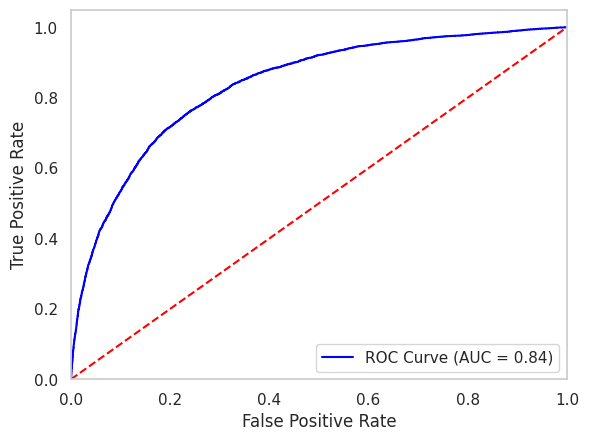

In [141]:
fpr, tpr, _ = roc_curve(y_val, y_val_pred_prob)
plt.plot(fpr, tpr, color="blue", label=f'ROC Curve (AUC = {roc_auc_val:.2f})')
plt.plot([0, 1], [0, 1], color="red", linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid()
plt.show()

### Features Importance

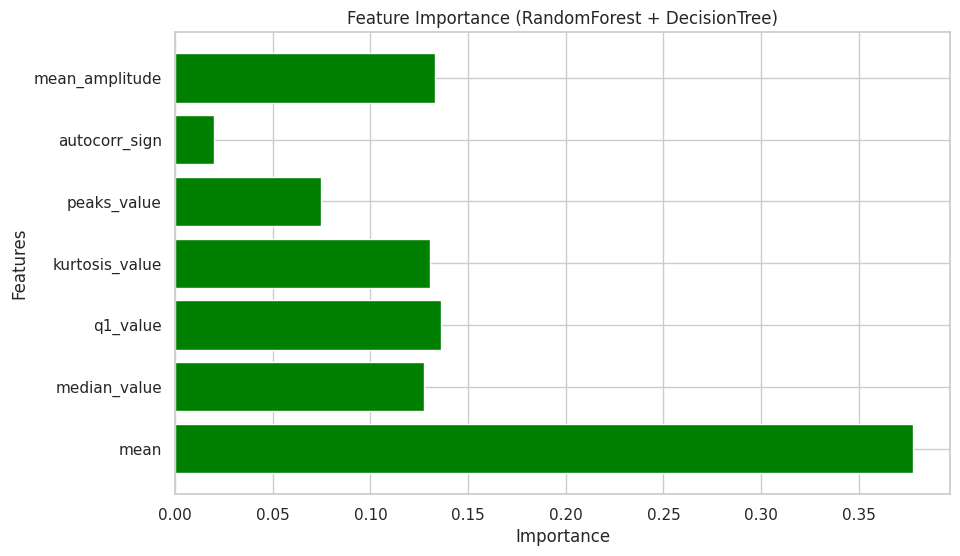

In [142]:
rf = clf.named_estimators_['rf'] 
dtree = clf.named_estimators_['dtree'] 

rf_importances = rf.feature_importances_
dtree_importances = dtree.feature_importances_

mean_importances = np.mean([rf_importances, dtree_importances], axis=0)

plt.figure(figsize=(10, 6))
plt.barh(X_train.columns, mean_importances, color='green')
plt.title("Feature Importance (RandomForest + DecisionTree)")
plt.xlabel("Importance")
plt.ylabel("Features")
plt.show()

### Making predictions

In [143]:
merged_test_df_fd

,mean,std_value,min_value,max_value,median_value,q1_value,q3_value,skewness_value,kurtosis_value,peaks_value,autocorr_sign,mean_amplitude
0,0.037895,1.505985,-3.140000,3.13,-0.010,-0.950000,1.0100,0.066034,-0.416815,16,1,4.310345
1,-0.016909,1.249663,-2.240000,3.85,-0.080,-0.950000,0.5150,0.874569,0.857138,19,0,3.750000
2,-0.039569,1.000514,-1.450000,3.46,-0.160,-0.785000,0.5400,0.963947,1.074141,16,1,2.571429
3,0.159231,1.313112,-2.730000,3.43,0.110,-0.710000,0.7200,0.384563,-0.054884,26,0,4.775000
4,-0.094705,1.243279,-2.660000,2.57,-0.090,-1.030000,0.9100,-0.032288,-0.534065,23,1,3.969697
...,...,...,...,...,...,...,...,...,...,...,...,...
19995,-0.022217,1.077283,-1.550000,3.86,-0.275,-0.767500,0.4550,1.511330,2.713467,26,1,3.738095
19996,0.072439,1.381959,-3.000000,2.78,0.260,-1.010000,1.2600,-0.276615,-0.638944,19,1,3.785714
19997,0.068727,1.173802,-3.660000,1.91,0.290,-0.235000,0.7700,-1.238295,1.490626,15,1,2.464286
19998,-0.037175,1.177763,-2.801675,2.40,-0.180,-0.958756,0.9375,0.118480,-0.641838,15,0,2.666667


In [144]:
merged_test_df_fd.shape

(20000, 12)

In [155]:
select_feat_test = ['mean', 'median_value', 'q1_value', 'kurtosis_value', 'peaks_value', 'autocorr_sign', 'mean_amplitude']
test = merged_test_df_fd[select_feat_test]

final_test_df = test_df[['id']].merge(test, left_index=True, right_index=True, how='left')

scaled_test = scaler.fit_transform(final_test_df.drop(columns=['id']))  

scaled_test_df = pd.DataFrame(scaled_test, columns=select_feat_test) 

In [145]:
# select_feat_test = ['mean', 'median_value', 'q1_value', 'kurtosis_value', 'peaks_value', 'autocorr_sign', 'mean_amplitude']
# test = merged_test_df_fd[select_feat_test]

# final_test_df = test_df[['id']].merge(test, left_index=True, right_index=True, how='left')
# scaled_test = scaler.fit_transform(final_test_df)
# # scaled_test_df = pd.DataFrame(scaled_data, columns=X.columns)

In [157]:
scaled_test_df.shape

(20000, 7)

In [158]:
scaled_test_df.head()

,mean,median_value,q1_value,kurtosis_value,peaks_value,autocorr_sign,mean_amplitude
0,0.635928,0.434284,-0.438395,-0.266170,-0.577386,0.687256,1.152329
1,0.139040,0.094621,-0.438395,0.035674,-0.031644,-1.455063,0.417700
2,-0.066410,-0.293565,0.280043,0.087089,-0.577386,0.687256,-1.127443
3,1.736041,1.016563,0.606605,-0.180416,1.241755,-1.455063,1.761506
4,-0.566314,0.046098,-0.786728,-0.293951,0.696013,0.687256,0.705729


In [159]:
sample_submission.shape

(20001, 2)

In [160]:
sample_submission.head()

,id,score
0,6125.0,0.757097
1,26781.0,0.346173
2,13333.0,0.431305
3,53218.0,0.847472
4,84204.0,0.065298


In [161]:
y_test_pred_prob = clf.predict_proba(scaled_test_df)[:, 1]

submission = pd.DataFrame({
    'id': test_df['id'],  
    'score': y_test_pred_prob   
})

submission.to_csv('submission.csv', index=False)

print("Файл submission.csv успешно создан!")

Файл submission.csv успешно создан!
